# Init

In [ ]:
import sys
import gym
import numpy as np
import random
from collections import defaultdict

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls drive/'My Drive'/RL/gym-foo3

gym_foo  gym_foo.egg-info  setup.py


In [ ]:
!pip install -e drive/'My Drive'/RL/gym-foo3/

Obtaining file:///content/drive/My%20Drive/RL/gym-foo3
  Running setup.py develop for gym-foo


In [ ]:
import gym_foo

In [ ]:
# env = gym.make('Blackjack-v0')
env = gym.make('gym_foo:foo-v0')

In [ ]:
#help(env) #this will explain the env

#Q-learning (Task 4)

Посмотрим стратегию со split для Q-learning

In [ ]:
def epsilon_greedy(env, Q, state, nA, eps):
    """Selects epsilon-greedy action for supplied state.
    
    Params
    ======
        Q (dictionary): action-value function
        state (int): current state
        nA (int): number actions in the environment
        eps (float): epsilon
    """
    if random.random() > eps: # select greedy action with probability epsilon
        return np.argmax(Q[state])
    else:                     # otherwise, select an action randomly
        return env.random_action() #random.choice(np.arange(env.action_space.n))
        

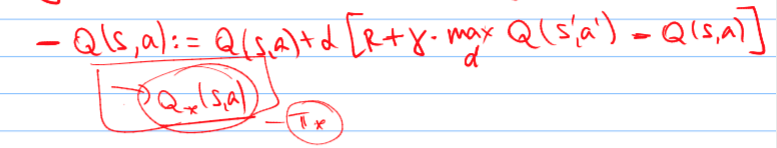

In [ ]:
def update_Q_sarsamax(alpha, gamma, Q, state, action, R, next_state=None):
    """Returns updated Q-value for the most recent experience."""
    Q_current = Q[state][action]  # estimate in Q-table (for current state, action pair)
    if next_state is not None:
        maxQ_next = np.max(Q[next_state])
    else: 
        maxQ_next = 0  # value of next state 

    Qsa_new = Q_current + alpha * (R + gamma * maxQ_next - Q_current) # get updated value 
    return Qsa_new

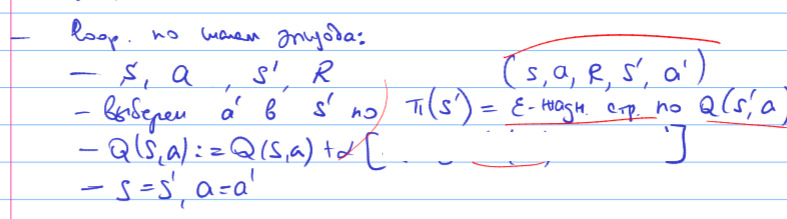

In [ ]:
def generate_episode_Q_sarsamax(bj_env, Q, epsilon, nA, alpha, gamma):
    # generates an episode from following the epsilon-greedy policy
    episode = []
    score = 0                                              # initialize score
    state = bj_env.reset()
    while True:
        # eps greedy
        if random.random() > epsilon:
            action = np.argmax(Q[state])
        else:
            action = bj_env.random_action() #random.choice(np.arange(env.action_space.n))

        next_state, reward, done, info = bj_env.step(action)  # take action A, observe R, S'
        episode.append((state, action, reward))
        
        # Q update
        score += reward                                       # add reward to agent's score
        Q[state][action] = update_Q_sarsamax(alpha, gamma, Q, \
                                             state, action, reward, next_state)        
        state = next_state                                 # S <- S'
        if done: # note: no A <- A'
            break
    return episode, Q 

In [ ]:
nA = env.action_space.n
Q = defaultdict(lambda: np.zeros(nA))

for i in range(10):
    print(generate_episode_Q_sarsamax(env, Q, 0.1, nA, 0.015, 1)[0])

[((20, 0, 7, False, False, -4.5), 0, -1.0)]
[((13, 0, 4, False, False, -1.5), 0, 0.0)]
[((16, 0, 9, False, False, 0.5), 0, -1.0)]
[((16, 0, 10, True, False, -3.0), 0, 0.0)]
[((10, 0, 6, False, False, -1.5), 0, 0.0)]
[((14, 0, 5, False, False, 1.5), 0, -1.0)]
[((18, 0, 8, False, False, -1.0), 0, -1.0)]
[((8, 0, 9, False, False, 1.5), 0, 0.0)]
[((8, 0, 5, False, False, 4.0), 0, 0.0)]
[((15, 0, 9, False, False, 2.5), 0, 0.0)]


In [ ]:
def generate_episode_Q_sarsamax_test(bj_env, Q, nA, alpha, gamma):
    # generates an episode from following the epsilon-greedy policy
    episode = []
    score = 0
    state = bj_env.reset()
    while True:
        action = np.argmax(Q[state])

        next_state, reward, done, info = bj_env.step(action)  # take action A, observe R, S'
        episode.append((state, action, reward))
      
        score += reward                                       # add reward to agent's score
        Q[state][action] = update_Q_sarsamax(alpha, gamma, Q, \
                                             state, action, reward, next_state)        
        state = next_state          

        if done: 
            break
    return episode

In [ ]:
def average_reward_q(env, Q, nA, alpha, gamma, n_episodes=100_000):

    rewards = 0
    epsilon = 0
    for _ in range(n_episodes):
        rewards += generate_episode_Q_sarsamax_test(env, Q, nA, alpha, gamma)[-1][-1]
    return rewards / n_episodes

In [ ]:
def q_learning(env, num_episodes, alpha, gamma=1.0, epsmin=0.01):
    """Q-Learning - TD Control
    
    Params
    ======
        num_episodes (int): number of episodes to run the algorithm
        alpha (float): learning rate
        gamma (float): discount factor
        plot_every (int): number of episodes to use when calculating average score
    """
    nA = env.action_space.n                # number of actions
    Q = defaultdict(lambda: np.zeros(nA))  # initialize empty dictionary of arrays
    
    rewards_list = []
    rew = 0
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        score = 0                                              # initialize score
        state = env.reset()                                    # start episode
        eps = max(1.0 / i_episode ,epsmin)                                 # set value of epsilon
        
        # для каждого шага в эпизоде
        episode, Q = generate_episode_Q_sarsamax(env, Q, eps, nA, alpha, gamma)
        
      
        rew += episode[-1][-1]
        if i_episode % 10_000 == 0:
            rewards_list.append(average_reward_q(env, Q, nA, alpha, gamma))
    
    print(rew / num_episodes)

    return Q, rewards_list

In [ ]:
from tqdm.notebook import  tqdm

rewards_sarsa = []

for j in tqdm(range(0, 11, 2)): #0, 11, 2
    Q, rewards = q_learning(env, 100_000, 0.015, gamma= j / 10)
    rewards_sarsa.append(rewards)

Episode 100000/100000-0.0284
Episode 100000/100000-0.03161
Episode 100000/100000-0.02984
Episode 100000/100000-0.03148
Episode 100000/100000-0.02931
Episode 100000/100000-0.03028



Ура! Мы обыграли казино

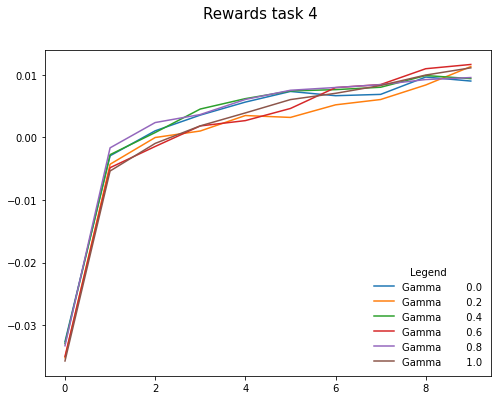

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, figsize=(8, 6))
fig.suptitle('Rewards task 4', fontsize=15)
for i in range(len(rewards_sarsa)):
    #print(i)
    ax.plot(rewards_sarsa[i], label="Gamma {:10.1f}".format((i*2)/10))
plt.legend(loc="lower right", title="Legend", frameon=False)
plt.show()

Rewards task 3

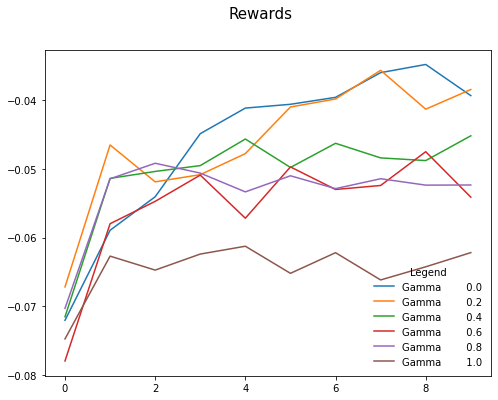

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, figsize=(8, 6))
fig.suptitle('Rewards', fontsize=15)
for i in range(len(rewards_sarsa)):
    #print(i)
    ax.plot(rewards_sarsa[i], label="Gamma {:10.1f}".format((i*2)/10))
plt.legend(loc="lower right", title="Legend", frameon=False)
plt.show()

Rewards task 1

In [ ]:
rewards_sarsa_task1 = [
            [-0.07009, -0.06527, -0.06055, -0.06051, -0.06744, -0.06953, -0.05914, -0.06047, -0.05856, -0.05724],
            [-0.06272, -0.05656, -0.0559, -0.0532, -0.05553, -0.06841, -0.06213, -0.06631, -0.06202, -0.05126],
            [-0.08279, -0.07645, -0.07653, -0.07693, -0.07315, -0.07475, -0.0801, -0.07202, -0.08024, -0.08655],  
            [-0.10382, -0.11113, -0.11589, -0.11154, -0.11321, -0.1215, -0.12104, -0.1184, -0.11644, -0.12079],  
            [-0.12726, -0.14881, -0.15007, -0.1474, -0.15269, -0.1552, -0.1515, -0.15, -0.15445, -0.15269],  
            [-0.16104, -0.17309, -0.17258, -0.18122, -0.18352, -0.18219, -0.18175, -0.18328, -0.18081, -0.1806]
            ]

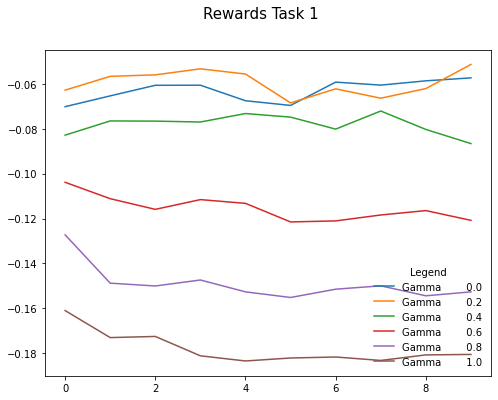

In [ ]:
fig, ax = plt.subplots(1, figsize=(8, 6))
fig.suptitle('Rewards Task 1', fontsize=15)
for i in range(len(rewards_sarsa_task1)):
    #print(i)
    ax.plot(rewards_sarsa_task1[i], label="Gamma {:10.1f}".format((i*2)/10))
plt.legend(loc="lower right", title="Legend", frameon=False)
plt.show()